In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
notebook_name = 'real1_Abalone'  # Direct assignment for this specific notebook

In [5]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features
y = abalone.data.targets

#X = pd.get_dummies(X, columns=['Sex'])
X = X.drop(columns=['Sex'])

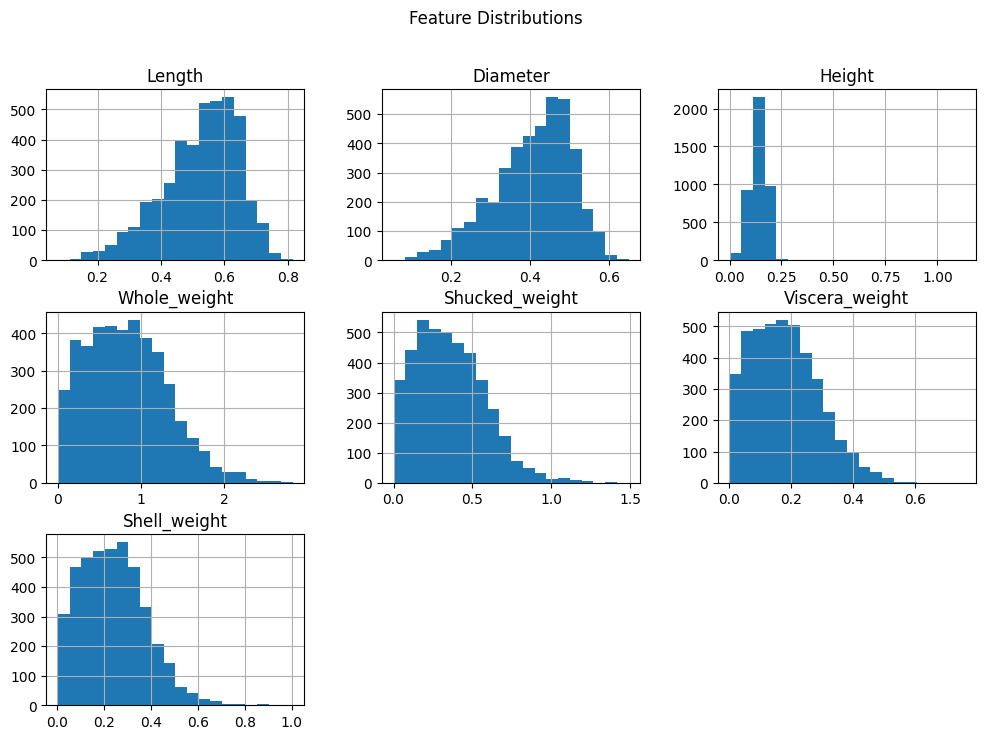

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

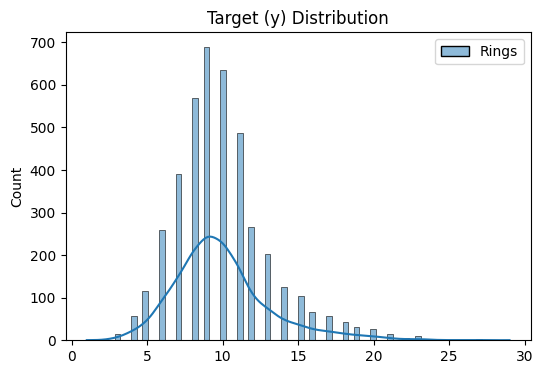

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
ndpost=1000
nskip=1000
n_trees=100

In [10]:
import comparison
import pandas as pd

# Perform Gelman-Rubin R-hat comparison across different burnin values
rhat_df = comparison.gelman_rubin_r_compare(
    X, y, 
    burnin_values=[0, 50, 100, 200, 500, 1000],  # Different burnin periods to test
    window=1000,                                  # Fixed analysis window size
    n_runs=10, 
    n_chains=4, 
    n_trees=n_trees, 
    n_jobs=-2
)

# Display convergence diagnostics grouped by burnin period
print("Gelman-Rubin R̂ comparison by burnin period:")
for burnin in [0, 50, 100, 200, 500, 1000]:
    burnin_data = rhat_df[rhat_df['burnin'] == burnin]
    print(f"\nBurnin = {burnin}:")
    print(burnin_data[['MultiBART_Rhat_Sigma2', 'DefaultBART_Rhat_Sigma2', 
                       'MultiBART_Rhat_RMSE', 'DefaultBART_Rhat_RMSE']].describe())

Gelman-Rubin R̂ comparison by burnin period:

Burnin = 0:
       MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
count              10.000000                10.000000            10.000000   
mean                1.174625                 1.165138             1.160490   
std                 0.083412                 0.052410             0.049060   
min                 1.068099                 1.097720             1.077882   
25%                 1.128668                 1.127650             1.149063   
50%                 1.161139                 1.155511             1.159995   
75%                 1.192000                 1.211453             1.185215   
max                 1.352210                 1.245493             1.233905   

       DefaultBART_Rhat_RMSE  
count              10.000000  
mean                1.172767  
std                 0.078300  
min                 1.076392  
25%                 1.122181  
50%                 1.153204  
75%                 1.

In [11]:
# Save R-hat convergence results to CSV
rhat_df.to_csv(f"results/{notebook_name}_rhat.csv", index=False)

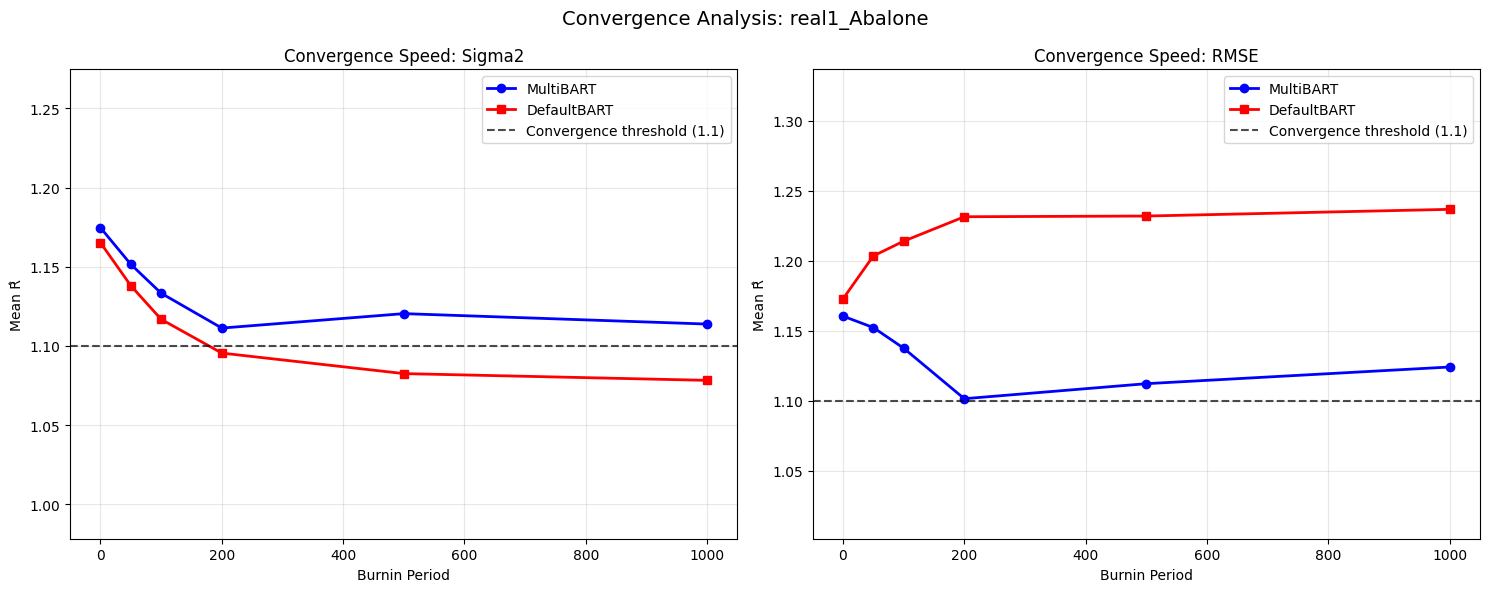


Convergence Summary:
Burnin	MultiBART_Sigma2	DefaultBART_Sigma2	MultiBART_RMSE	DefaultBART_RMSE
0	1.175		1.165		1.160		1.173
50	1.152		1.138		1.152		1.203
100	1.133		1.117		1.138		1.214
200	1.111		1.095		1.101		1.231
500	1.120		1.083		1.112		1.232
1000	1.114		1.078		1.124		1.237


In [12]:
# Create visualizations for R-hat values across different burnin periods
import matplotlib.pyplot as plt

# Calculate mean R-hat values for each burnin and method
burnin_values = [0, 50, 100, 200, 500, 1000]

# Prepare data for line plots
sigma2_multibart_means = []
sigma2_defaultbart_means = []
sigma2_multibart_stds = []
sigma2_defaultbart_stds = []

rmse_multibart_means = []
rmse_defaultbart_means = []
rmse_multibart_stds = []
rmse_defaultbart_stds = []

for burnin in burnin_values:
    burnin_data = rhat_df[rhat_df['burnin'] == burnin]
    
    # Sigma2 statistics
    sigma2_multibart_means.append(burnin_data['MultiBART_Rhat_Sigma2'].mean())
    sigma2_defaultbart_means.append(burnin_data['DefaultBART_Rhat_Sigma2'].mean())
    sigma2_multibart_stds.append(burnin_data['MultiBART_Rhat_Sigma2'].std())
    sigma2_defaultbart_stds.append(burnin_data['DefaultBART_Rhat_Sigma2'].std())
    
    # RMSE statistics
    rmse_multibart_means.append(burnin_data['MultiBART_Rhat_RMSE'].mean())
    rmse_defaultbart_means.append(burnin_data['DefaultBART_Rhat_RMSE'].mean())
    rmse_multibart_stds.append(burnin_data['MultiBART_Rhat_RMSE'].std())
    rmse_defaultbart_stds.append(burnin_data['DefaultBART_Rhat_RMSE'].std())

# Create line plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Sigma2 R-hat trends
ax1.plot(burnin_values, sigma2_multibart_means, 'o-', label='MultiBART', 
         linewidth=2, markersize=6, color='blue')
# ax1.fill_between(burnin_values, 
#                  [m - s for m, s in zip(sigma2_multibart_means, sigma2_multibart_stds)],
#                  [m + s for m, s in zip(sigma2_multibart_means, sigma2_multibart_stds)],
#                  alpha=0.2, color='blue')

ax1.plot(burnin_values, sigma2_defaultbart_means, 's-', label='DefaultBART', 
         linewidth=2, markersize=6, color='red')
# ax1.fill_between(burnin_values, 
#                  [m - s for m, s in zip(sigma2_defaultbart_means, sigma2_defaultbart_stds)],
#                  [m + s for m, s in zip(sigma2_defaultbart_means, sigma2_defaultbart_stds)],
#                  alpha=0.2, color='red')

ax1.axhline(y=1.1, color='black', linestyle='--', alpha=0.7, label='Convergence threshold (1.1)')
ax1.set_xlabel('Burnin Period')
ax1.set_ylabel('Mean R̂')
ax1.set_title('Convergence Speed: Sigma2')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([min(min(sigma2_multibart_means), min(sigma2_defaultbart_means)) - 0.1, 
              max(max(sigma2_multibart_means), max(sigma2_defaultbart_means)) + 0.1])

# Plot RMSE R-hat trends
ax2.plot(burnin_values, rmse_multibart_means, 'o-', label='MultiBART', 
         linewidth=2, markersize=6, color='blue')
# ax2.fill_between(burnin_values, 
#                  [m - s for m, s in zip(rmse_multibart_means, rmse_multibart_stds)],
#                  [m + s for m, s in zip(rmse_multibart_means, rmse_multibart_stds)],
#                  alpha=0.2, color='blue')

ax2.plot(burnin_values, rmse_defaultbart_means, 's-', label='DefaultBART', 
         linewidth=2, markersize=6, color='red')
# ax2.fill_between(burnin_values, 
#                  [m - s for m, s in zip(rmse_defaultbart_means, rmse_defaultbart_stds)],
#                  [m + s for m, s in zip(rmse_defaultbart_means, rmse_defaultbart_stds)],
#                  alpha=0.2, color='red')

ax2.axhline(y=1.1, color='black', linestyle='--', alpha=0.7, label='Convergence threshold (1.1)')
ax2.set_xlabel('Burnin Period')
ax2.set_ylabel('Mean R̂')
ax2.set_title('Convergence Speed: RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([min(min(rmse_multibart_means), min(rmse_defaultbart_means)) - 0.1, 
              max(max(rmse_multibart_means), max(rmse_defaultbart_means)) + 0.1])

plt.suptitle(f'Convergence Analysis: {notebook_name}', fontsize=14)
plt.tight_layout()
plt.show()

# Print convergence summary
print("\nConvergence Summary:")
print("Burnin\tMultiBART_Sigma2\tDefaultBART_Sigma2\tMultiBART_RMSE\tDefaultBART_RMSE")
for i, burnin in enumerate(burnin_values):
    print(f"{burnin}\t{sigma2_multibart_means[i]:.3f}\t\t{sigma2_defaultbart_means[i]:.3f}\t\t{rmse_multibart_means[i]:.3f}\t\t{rmse_defaultbart_means[i]:.3f}")

In [13]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

# Compare model performance across different burnin values
mse_results = comparison.bart_mse_comparison(
    X, y, 
    burnin_values=[0, 50, 100, 200, 500, 1000],  # Different burnin periods to test
    window=1000,                                  # Fixed analysis window size
    n_runs=10, 
    n_trees=n_trees, 
    n_jobs=-2
)

INFO:2025-10-08 05:30:19,682:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-08 05:30:19,974:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-08 05:30:20,050:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

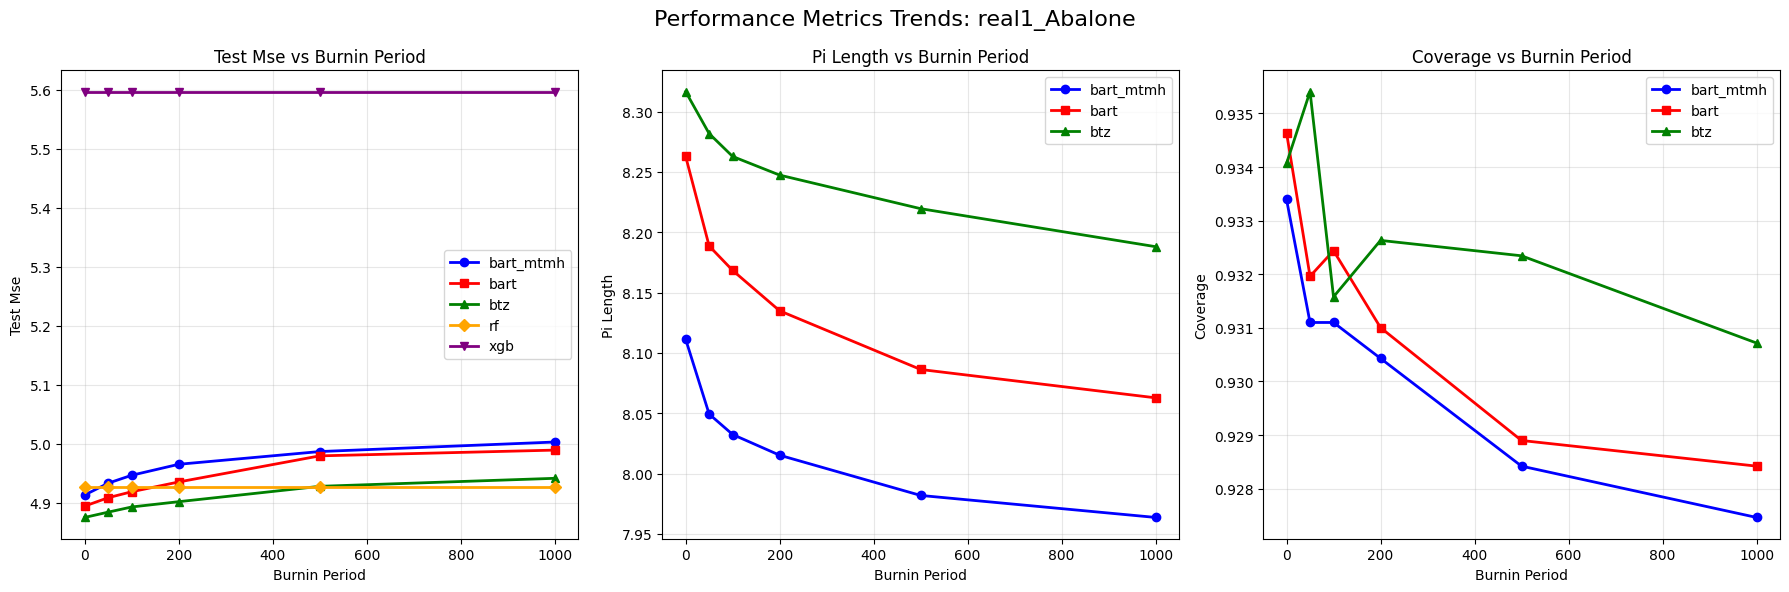


=== Performance Summary Across Burnin Periods ===

TEST_MSE Summary:
Burnin	   bart_mtmh	        bart	         btz	          rf	         xgb
0	      4.9133	      4.8945	      4.8753	      4.9276	      5.5966
50	      4.9334	      4.9087	      4.8843	      4.9276	      5.5966
100	      4.9467	      4.9188	      4.8930	      4.9276	      5.5966
200	      4.9653	      4.9354	      4.9019	      4.9276	      5.5966
500	      4.9869	      4.9796	      4.9280	      4.9276	      5.5966
1000	      5.0030	      4.9893	      4.9415	      4.9276	      5.5966

PI_LENGTH Summary:
Burnin	   bart_mtmh	        bart	         btz
0	      8.1114	      8.2629	      8.3165
50	      8.0493	      8.1886	      8.2817
100	      8.0324	      8.1684	      8.2628
200	      8.0153	      8.1349	      8.2474
500	      7.9819	      8.0863	      8.2195
1000	      7.9637	      8.0628	      8.1881

COVERAGE Summary:
Burnin	   bart_mtmh	        bart	         btz
0	      0.9334	      0.9346	      0.9341
50	      0.9311	  

In [14]:
# Analyze and visualize performance trends across burnin periods
import matplotlib.pyplot as plt

# Extract and organize data for line plots
burnin_values = [0, 50, 100, 200, 500, 1000]
metrics = ['test_mse', 'pi_length', 'coverage']

# Organize data by method and metric
data_by_metric = {}

for metric in metrics:
    data_by_metric[metric] = {}
    # Get all method names from the first burnin period
    methods = list(mse_results[burnin_values[0]][metric].columns)
    
    for method in methods:
        data_by_metric[metric][method] = []
        
        # Collect mean values across burnin periods
        for burnin in burnin_values:
            mean_val = mse_results[burnin][metric][method].mean()
            data_by_metric[metric][method].append(mean_val)

# Create line plots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Plot lines for each method
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    markers = ['o', 's', '^', 'D', 'v']
    
    methods = list(data_by_metric[metric].keys())
    for j, method in enumerate(methods):
        ax.plot(burnin_values, data_by_metric[metric][method], 
                marker=markers[j % len(markers)], 
                color=colors[j % len(colors)],
                linewidth=2, markersize=6, label=method)
    
    ax.set_xlabel('Burnin Period')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} vs Burnin Period')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove the extra subplot
if len(metrics) < len(axes):
    fig.delaxes(axes[-1])

plt.suptitle(f'Performance Metrics Trends: {notebook_name}', fontsize=16)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Performance Summary Across Burnin Periods ===")
for metric in metrics:
    print(f"\n{metric.upper()} Summary:")
    print("Burnin\t" + "\t".join(f"{method:>12}" for method in data_by_metric[metric].keys()))
    
    for i, burnin in enumerate(burnin_values):
        values = [f"{data_by_metric[metric][method][i]:.4f}" for method in data_by_metric[metric].keys()]
        print(f"{burnin}\t" + "\t".join(f"{val:>12}" for val in values))

In [15]:
# Save performance results for each burnin period
for burnin in [0, 50, 100, 200, 500, 1000]:
    for metric_name, metric_df in mse_results[burnin].items():
        csv_name = f"results/{notebook_name}_{metric_name}_burnin{burnin}.csv"
        metric_df.to_csv(csv_name, index=False)

print(f"Results saved with prefix: {notebook_name}")

Results saved with prefix: real1_Abalone


## Multi-tries

In [16]:
from multi_tries import multi_tries_burnin_comparison
import pandas as pd

# Load existing results if available
csv_path = f"results/{notebook_name}_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

# Run multi-tries performance analysis
df = multi_tries_burnin_comparison(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    burnin_values=[0, 50, 100, 200, 500, 1000],
    window=1000,
    n_runs=10, n_chains=4,
    n_trees=n_trees, n_jobs=-2
)

# Combine with existing results if available
if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

# Save results with dynamic filename
df.to_csv(f"results/{notebook_name}_tries.csv", index=False)

Processing multi_tries = 1...
Processing multi_tries = 5...
Processing multi_tries = 10...
Processing multi_tries = 50...


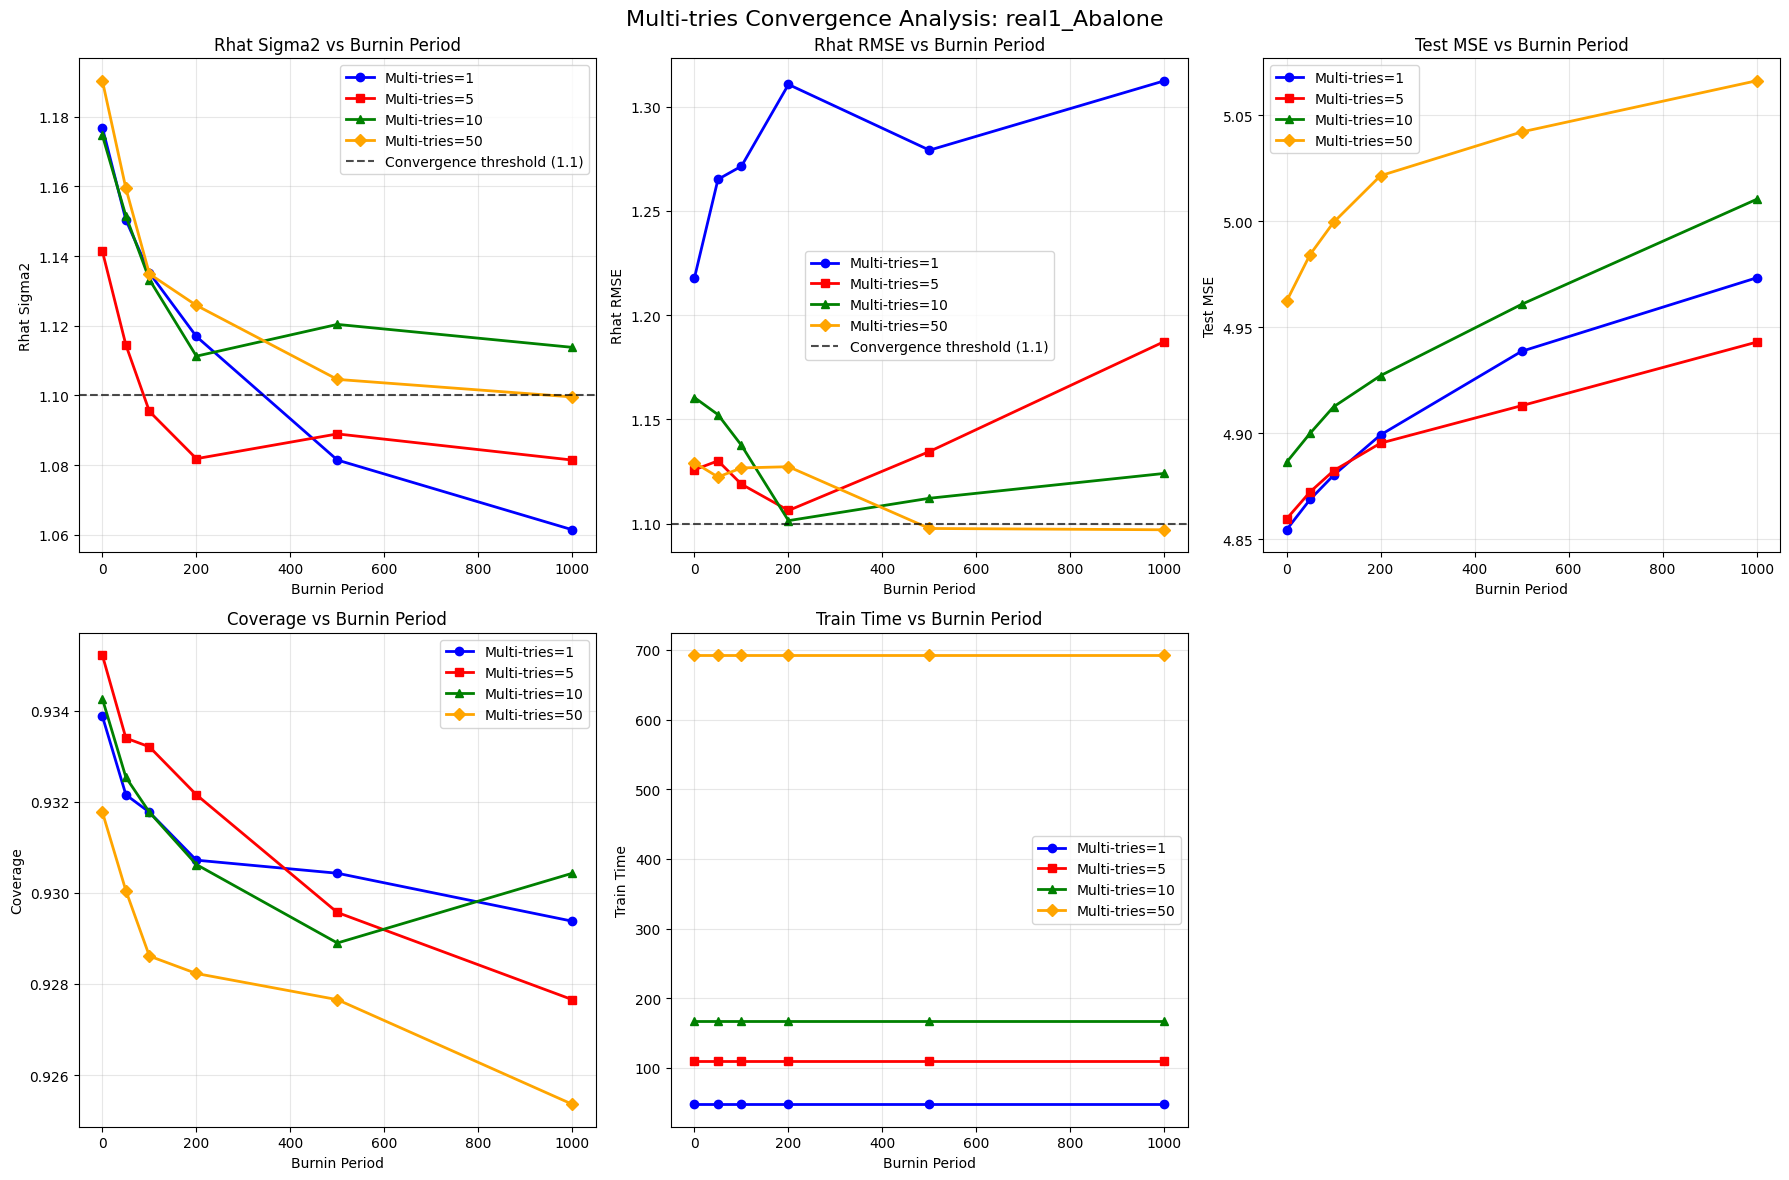


=== Multi-tries Performance Summary ===

Rhat_Sigma2 Summary:
Burnin	Multi       1	Multi       5	Multi      10	Multi      50
0	    1.1769	    1.1414	    1.1746	    1.1903
50	    1.1503	    1.1145	    1.1515	    1.1594
100	    1.1352	    1.0954	    1.1333	    1.1349
200	    1.1169	    1.0818	    1.1113	    1.1258
500	    1.0814	    1.0889	    1.1204	    1.1046
1000	    1.0614	    1.0814	    1.1138	    1.0995

Rhat_RMSE Summary:
Burnin	Multi       1	Multi       5	Multi      10	Multi      50
0	    1.2180	    1.1259	    1.1605	    1.1293
50	    1.2651	    1.1302	    1.1523	    1.1224
100	    1.2714	    1.1190	    1.1376	    1.1268
200	    1.3106	    1.1064	    1.1015	    1.1274
500	    1.2791	    1.1346	    1.1122	    1.0977
1000	    1.3123	    1.1874	    1.1241	    1.0971

Test_MSE Summary:
Burnin	Multi       1	Multi       5	Multi      10	Multi      50
0	    4.8544	    4.8595	    4.8863	    4.9623
50	    4.8687	    4.8723	    4.8999	    4.9843
100	    4.8801	    4.8823	    4.9124	    4.9

In [17]:
# Visualize multi-tries comparison results
import matplotlib.pyplot as plt

# Organize data for visualization
multi_tries_list = df['multi_tries'].unique()
burnin_values = df['burnin'].unique()
metrics = ['Rhat_Sigma2', 'Rhat_RMSE', 'Test_MSE', 'Coverage', 'Train_Time']

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors = ['blue', 'red', 'green', 'orange', 'purple']
markers = ['o', 's', '^', 'D', 'v']

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Plot line for each multi_tries value
    for j, multi_tries in enumerate(sorted(multi_tries_list)):
        # Extract data for this multi_tries value
        subset = df[df['multi_tries'] == multi_tries]
        
        # Calculate mean values for each burnin
        means = []
        for burnin in sorted(burnin_values):
            burnin_data = subset[subset['burnin'] == burnin][metric]
            means.append(burnin_data.mean())
        
        ax.plot(sorted(burnin_values), means, 
                marker=markers[j % len(markers)], 
                color=colors[j % len(colors)],
                linewidth=2, markersize=6, 
                label=f'Multi-tries={multi_tries}')
    
    # Add convergence threshold for R-hat metrics
    if 'Rhat' in metric:
        ax.axhline(y=1.1, color='black', linestyle='--', alpha=0.7, 
                   label='Convergence threshold (1.1)')
    
    ax.set_xlabel('Burnin Period')
    ax.set_ylabel(metric.replace('_', ' '))
    ax.set_title(f'{metric.replace("_", " ")} vs Burnin Period')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove the extra subplot
fig.delaxes(axes[-1])

plt.suptitle(f'Multi-tries Convergence Analysis: {notebook_name}', fontsize=16)
plt.tight_layout()
plt.show()

# Print detailed summary by multi_tries and burnin
print("\n=== Multi-tries Performance Summary ===")
for metric in metrics:
    print(f"\n{metric} Summary:")
    print("Burnin\t" + "\t".join(f"Multi{mt:>8}" for mt in sorted(multi_tries_list)))
    
    for burnin in sorted(burnin_values):
        values = []
        for multi_tries in sorted(multi_tries_list):
            subset = df[(df['multi_tries'] == multi_tries) & (df['burnin'] == burnin)]
            mean_val = subset[metric].mean()
            values.append(f"{mean_val:.4f}")
        print(f"{burnin}\t" + "\t".join(f"{val:>10}" for val in values))